In [1]:
# script to save the rankings for the mechanism
import os
import re
import sys
import glob
import copy
import yaml
import pickle
import subprocess
import numpy as np
import pandas as pd

import cantera as ct

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


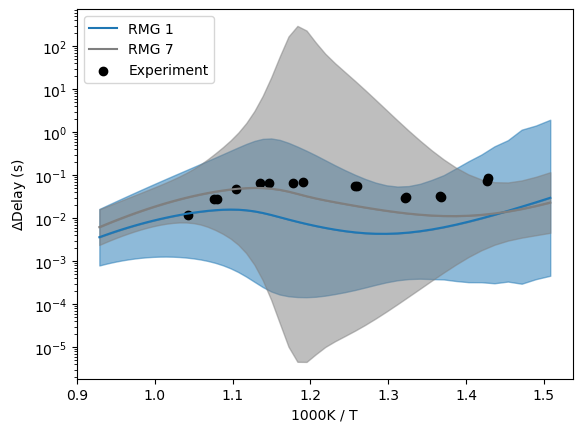

In [43]:
labels = run_order = ['RMG 1', 'RMG 7']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = colors[7]
for i, analysis_dir in enumerate([
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/analysis',
#     '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/analysis',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/analysis'
]):
    

    # load from files
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))

    base_delay_file = os.path.join(analysis_dir, '../', 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    # calculate things
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)
    table_index = 7

    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
    
    
    
    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[i], label=labels[i])

    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=0.5, color=colors[i])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=0.5, color=colors[i])


    ax = plt.gca()
    ax.set_yscale('log')

plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')
plt.legend()

# plt.title('Ignition Delay Uncertainties')
plt.xlabel('1000K / T')
plt.ylabel('$\Delta$Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()

    

In [4]:
# see how many of top contributers are thermo
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
table_index = 7

my_uncertainties = np.float_power(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), 0.5)
my_uncertainties = my_uncertainties[:, (table_index - 1) * K: table_index * K][:, 26]
my_uncertainties[np.isnan(my_uncertainties)] = -np.inf

# get the order
parameter_indices = np.arange(0, my_uncertainties.shape[0])
improvement_order = [x for _, x in sorted(zip(my_uncertainties, parameter_indices))][::-1]

count = 0
for i in range(0, 10):
    if improvement_order[i] < 110:
        count+= 1
print(count)

6


/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


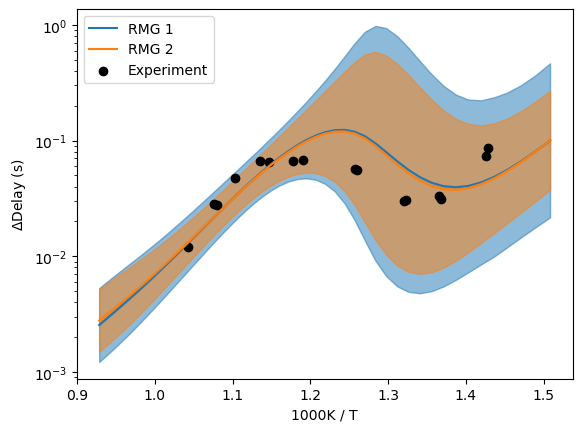

In [42]:
labels = run_order = ['RMG 1', 'RMG 2']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, analysis_dir in enumerate([
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/analysis',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/analysis',
]):
    

    # load from files
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))

    base_delay_file = os.path.join(analysis_dir, '../', 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    # calculate things
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)
    table_index = 7

    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
    
    
    
    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[i], label=labels[i])

    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=0.5, color=colors[i])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=0.5, color=colors[i])


    ax = plt.gca()
    ax.set_yscale('log')

plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')
plt.legend()

# plt.title('Ignition Delay Uncertainties')
plt.xlabel('1000K / T')
plt.ylabel('$\Delta$Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()

    

In [ ]:
# see how many of top contributers are thermo
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
table_index = 7

my_uncertainties = np.float_power(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), 0.5)
my_uncertainties = my_uncertainties[:, (table_index - 1) * K: table_index * K][:, 26]
my_uncertainties[np.isnan(my_uncertainties)] = -np.inf

# get the order
parameter_indices = np.arange(0, my_uncertainties.shape[0])
improvement_order = [x for _, x in sorted(zip(my_uncertainties, parameter_indices))][::-1]

count = 0
for i in range(0, 10):
    if improvement_order[i] < 110:
        count+= 1
print(count)

In [ ]:
total_uncertainty_mat.shape

In [ ]:
total_uncertainty.shape

# Break it into kinetics and thermo

/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


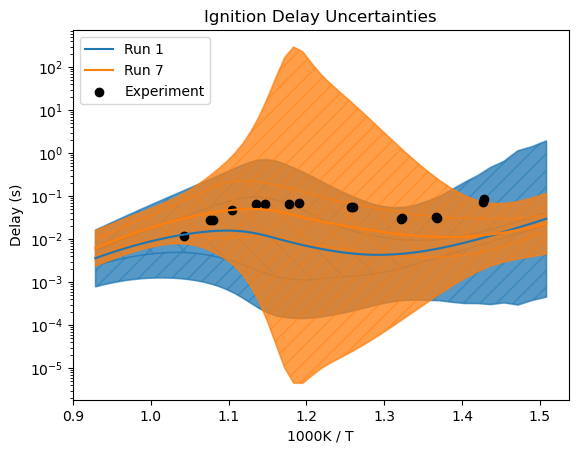

In [15]:
labels = run_order = ['Run 1', 'Run 7']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, analysis_dir in enumerate([
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/analysis',
#     '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/analysis',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501/analysis'
]):
    
    # First get the number of species from the yaml or chemkin
    gas = ct.Solution(os.path.join(analysis_dir, '../', 'chem_annotated.yaml'))
    N_sp = len(gas.species())
    
    
    # load from files
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))

    base_delay_file = os.path.join(analysis_dir, '../', 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    # calculate things
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    total_uncertainty_squared_sp = np.nansum(np.multiply(sensitivity_squared[:N_sp, :], np.float_power(total_uncertainty_mat[:N_sp, :], 2.0)), axis=0)
    total_uncertainty_sp = np.multiply(np.divide(total_uncertainty_squared_sp, total_uncertainty_squared), total_uncertainty)
    total_uncertainty_squared_rxn = np.nansum(np.multiply(sensitivity_squared[N_sp:, :], np.float_power(total_uncertainty_mat[N_sp:, :], 2.0)), axis=0)
    total_uncertainty_rxn = np.multiply(np.divide(total_uncertainty_squared_rxn, total_uncertainty_squared), total_uncertainty)
    
    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)
    table_index = 7

    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
    total_uncertainty7_sp = np.array(total_uncertainty_sp[(table_index - 1) * K: table_index * K])
    total_uncertainty7_rxn = np.array(total_uncertainty_rxn[(table_index - 1) * K: table_index * K])
    
    upper_bound_stddev_sp = np.exp(np.log(base_delays7) + total_uncertainty7_sp)
    lower_bound_stddev_sp = np.exp(np.log(base_delays7) - total_uncertainty7_sp)
    upper_bound_stddev_rxn = np.exp(np.log(base_delays7) + total_uncertainty7_sp + total_uncertainty7_rxn)
    lower_bound_stddev_rxn = np.exp(np.log(base_delays7) - total_uncertainty7_sp - total_uncertainty7_rxn)
    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
    
    
    
    
    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[i], label=labels[i])

    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=0.5, color=colors[i])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=0.5, color=colors[i])
    
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev_sp, alpha=0.5, color=colors[i], hatch="X")
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev_sp, base_delays7, alpha=0.5, color=colors[i], hatch="X")
    
    plt.fill_between(1000.0 / temperatures, upper_bound_stddev_sp, upper_bound_stddev_rxn, alpha=0.5, color=colors[i], hatch='//')
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev_rxn, lower_bound_stddev_sp, alpha=0.5, color=colors[i], hatch="//")


    ax = plt.gca()
    ax.set_yscale('log')

plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')
plt.legend()

plt.title('Ignition Delay Uncertainties')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()

    

In [34]:
U = np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0))[:, (table_index - 1) * K: table_index * K][:,24]
U[np.isnan(U)] = 0
parameter_indices = np.arange(0, total_uncertainty_mat.shape[0])
improvement_order = [x for _, x in sorted(zip(U, parameter_indices))][::-1]

for i in range(100):
    print(improvement_order[i])

5
59
74
60
312
148
295
251
71
75
250
417
334
56
299
325
70
33
21
55
73
23
35
667
19
294
58
418
4
310
34
311
13
228
384
525
11
20
62
85
46
249
50
244
128
90
669
43
146
12
154
24
298
446
637
39
15
162
32
245
9
22
82
665
36
66
14
391
26
490
305
171
401
61
25
27
30
313
16
28
263
387
18
40
45
144
17
31
256
48
92
392
666
57
107
122
402
68
51
151


/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


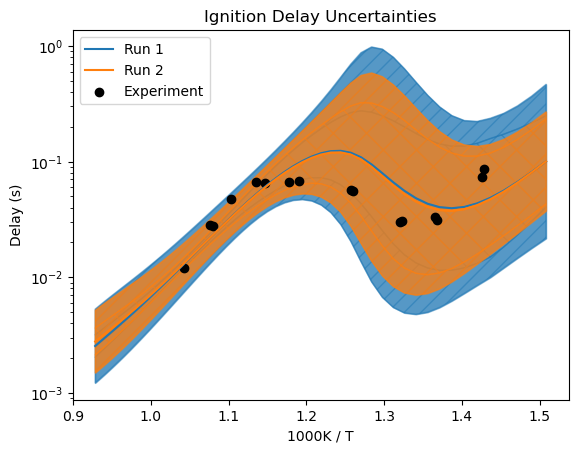

In [16]:
labels = run_order = ['Run 1', 'Run 2']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, analysis_dir in enumerate([
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240401/analysis',
    '/work/westgroup/harris.se/autoscience/fuels/butane/official/with_lib/butane_20240413/analysis',
]):
    
    # First get the number of species from the yaml or chemkin
    gas = ct.Solution(os.path.join(analysis_dir, '../', 'chem_annotated.yaml'))
    N_sp = len(gas.species())
    
    
    # load from files
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))

    base_delay_file = os.path.join(analysis_dir, '../', 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    # calculate things
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    total_uncertainty_squared_sp = np.nansum(np.multiply(sensitivity_squared[:N_sp, :], np.float_power(total_uncertainty_mat[:N_sp, :], 2.0)), axis=0)
    total_uncertainty_sp = np.multiply(np.divide(total_uncertainty_squared_sp, total_uncertainty_squared), total_uncertainty)
    total_uncertainty_squared_rxn = np.nansum(np.multiply(sensitivity_squared[N_sp:, :], np.float_power(total_uncertainty_mat[N_sp:, :], 2.0)), axis=0)
    total_uncertainty_rxn = np.multiply(np.divide(total_uncertainty_squared_rxn, total_uncertainty_squared), total_uncertainty)
    
    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)
    table_index = 7

    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
    total_uncertainty7_sp = np.array(total_uncertainty_sp[(table_index - 1) * K: table_index * K])
    total_uncertainty7_rxn = np.array(total_uncertainty_rxn[(table_index - 1) * K: table_index * K])
    
    upper_bound_stddev_sp = np.exp(np.log(base_delays7) + total_uncertainty7_sp)
    lower_bound_stddev_sp = np.exp(np.log(base_delays7) - total_uncertainty7_sp)
    upper_bound_stddev_rxn = np.exp(np.log(base_delays7) + total_uncertainty7_sp + total_uncertainty7_rxn)
    lower_bound_stddev_rxn = np.exp(np.log(base_delays7) - total_uncertainty7_sp - total_uncertainty7_rxn)
    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
    
    
    
    
    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[i], label=labels[i])

    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=0.5, color=colors[i])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=0.5, color=colors[i])
    
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev_sp, alpha=0.5, color=colors[i], hatch="X")
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev_sp, base_delays7, alpha=0.5, color=colors[i], hatch="X")
    
    plt.fill_between(1000.0 / temperatures, upper_bound_stddev_sp, upper_bound_stddev_rxn, alpha=0.5, color=colors[i], hatch='//')
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev_rxn, lower_bound_stddev_sp, alpha=0.5, color=colors[i], hatch="//")


    ax = plt.gca()
    ax.set_yscale('log')

plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')
plt.legend()

plt.title('Ignition Delay Uncertainties')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()

    